In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('../gemini_data.csv')

In [4]:
list(data.columns)

['Unnamed: 0',
 'patient_id',
 'genc_id',
 'hospital_id',
 'sex',
 'age',
 'mort_hosp',
 'discharge_date_time',
 'admit_date_time',
 'mr_diagnosis',
 'year',
 'los',
 'readmission_7',
 'readmission_28',
 'palliative',
 'los_er',
 'admit_via_ambulance',
 'er_admit_date_time',
 'er_discharge_date_time',
 'triage_level',
 'icd10_A00_B99',
 'icd10_C00_D49',
 'icd10_D50_D89',
 'icd10_E00_E89',
 'icd10_F01_F99',
 'icd10_G00_G99',
 'icd10_H00_H59',
 'icd10_H60_H95',
 'icd10_I00_I99',
 'icd10_J00_J99',
 'icd10_K00_K95',
 'icd10_L00_L99',
 'icd10_M00_M99',
 'icd10_N00_N99',
 'icd10_O00_O99',
 'icd10_Q00_Q99',
 'icd10_R00_R99',
 'icd10_S00_T88',
 'icd10_U07_U08',
 'icd10_Z00_Z99',
 'icd10_nan',
 'train',
 'test',
 'val']

In [5]:
import analysis

In [6]:
#read analysis configuration
conf = analysis.read_config()
print('Type of analysis to perform - {type}, on data from {source}'.format(type=conf.type, source=conf.input))

Type of analysis to perform - dataset, on data from ../gemini_data.csv


In [7]:
# run analysis and generate html report
analysis.main(conf)

/mnt/nfs/home/koshkinam/.conda/envs/test_env/lib/python3.8/site-packages/evidently/analyzers/data_drift_analyzer.py:19: RuntimeWarning: invalid value encountered in double_scalars
  return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))


dict_keys(['age', 'los_er', 'hospital_id', 'sex', 'mort_hosp', 'readmission_7', 'readmission_28', 'palliative', 'icd10_A00_B99', 'icd10_C00_D49', 'icd10_D50_D89', 'icd10_E00_E89', 'icd10_F01_F99', 'icd10_G00_G99', 'icd10_H00_H59', 'icd10_H60_H95', 'icd10_I00_I99', 'icd10_J00_J99', 'icd10_K00_K95', 'icd10_L00_L99', 'icd10_M00_M99', 'icd10_N00_N99', 'icd10_O00_O99', 'icd10_Q00_Q99', 'icd10_R00_R99', 'icd10_S00_T88', 'icd10_U07_U08', 'icd10_Z00_Z99', 'los', 'n_features', 'n_drifted_features', 'share_drifted_features', 'dataset_drift'])


In [5]:
print(conf)

Namespace(categorical_features=['hospital_id', 'sex', 'mort_hosp', 'readmission_7', 'readmission_28', 'palliative', 'icd10_A00_B99', 'icd10_C00_D49', 'icd10_D50_D89', 'icd10_E00_E89', 'icd10_F01_F99', 'icd10_G00_G99', 'icd10_H00_H59', 'icd10_H60_H95', 'icd10_I00_I99', 'icd10_J00_J99', 'icd10_K00_K95', 'icd10_L00_L99', 'icd10_M00_M99', 'icd10_N00_N99', 'icd10_O00_O99', 'icd10_Q00_Q99', 'icd10_R00_R99', 'icd10_S00_T88', 'icd10_U07_U08', 'icd10_Z00_Z99', 'los'], config_file='gemini_analysis.conf', data_eval=[2016], data_ref=[2015], input='../gemini_data.csv', numerical_features=['age', 'los_er'], prediction='prediction', reference='../gemini_val_result.csv', report_path='../', slice='year', target='los', target_num=False, test='../gemini_test_result.csv', type='dataset')


In [6]:
# run analysis and generate html report (this time model performance comparison)
conf.type = 'performance'
analysis.main(conf)

In [1]:
#MLFlow history for analysis
# Display dataset drift analysis runs

import os
import json
import mlflow
import pandas as pd


def get_dataset_metrics_list(data):
     if ('metrics' in data.keys()) and data['metrics']:
        metrics = data['metrics']
        #timestamp = data['params']['timestamp']
        drift = 'No' if metrics['dataset_drift']==0 else 'Yes'
        return [drift, metrics['n_features'], metrics['n_drifted_features']]
     else:
        return ['-', '-', '-']

# List all existing experiments
all_experiments = mlflow.list_experiments()
exp_data = []
for exp in all_experiments:
    row = [exp.name, exp.artifact_location, exp.lifecycle_stage]
    exp_data.append(row)
exp_frame = pd.DataFrame(exp_data, columns = ['Name', 'Artifacts', 'Status'])
print(exp_frame)
    
exp = mlflow.get_experiment_by_name('DatasetAnalysis')
runs = mlflow.list_run_infos(exp.experiment_id, max_results=100)
table = []
for r in runs:
    exp_run = mlflow.get_run(r.run_id).to_dictionary()
    path = exp_run['info']['artifact_uri'][6:]
    config_file = os.path.join(path, 'config.json')
    if not os.path.isfile(config_file):
        continue
    with open(config_file) as f:
        data = json.load(f)
        row = [data['input'], data['slice'], data['data_ref'], data['data_eval']]
        row = row + get_dataset_metrics_list(exp_run['data'])
        table.append(row)
frame = pd.DataFrame(table, columns=['Input', 'Slice', 'Ref Slice', 'Eval Slice', 'Drift', 'Feat', 'Drift_Feat'])
print('------------------- Dataset Analysis ----------------------')
print(frame)

              Name                                          Artifacts  Status
0  DatasetAnalysis  file:///mnt/nfs/home/koshkinam/vector-delirium...  active
1          Default  file:///mnt/nfs/home/koshkinam/vector-delirium...  active
2  ModelComparison  file:///mnt/nfs/home/koshkinam/vector-delirium...  active
3       Prediction  file:///mnt/nfs/home/koshkinam/vector-delirium...  active
------------------- Dataset Analysis ----------------------
                                                Input Slice Ref Slice  \
0   /mnt/nfs/project/delirium/data/all_before_2018...              []   
1   /mnt/nfs/project/delirium/data/all_before_2018...  year    [2015]   
2   /mnt/nfs/project/delirium/data/all_before_2018...  year    [2015]   
3   /mnt/nfs/project/delirium/data/all_before_2018...  year    [2015]   
4   /mnt/nfs/project/delirium/data/all_before_2018...  year    [2015]   
5   /mnt/nfs/project/delirium/data/all_before_2018...  None        []   
6   /mnt/nfs/project/delirium/data/all_

In [2]:
# Display model comparison analysis runs
def get_model_metrics_list(data):
    if ('metrics' in data.keys()) and data['metrics']:
        metrics = data['metrics']
        return [metrics['ref_accuracy'], metrics['test_accuracy'], metrics['ref_f1'], metrics['test_f1']]
    else:
        return ['-', '-', '-']

exp = mlflow.get_experiment_by_name('ModelComparison')
runs = mlflow.list_run_infos(exp.experiment_id, max_results=100)
table = []
for r in runs:
    exp_run = mlflow.get_run(r.run_id).to_dictionary()
    path = exp_run['info']['artifact_uri'][6:]
    config_file = os.path.join(path, 'config.json')
    if not os.path.isfile(config_file):
        continue
    with open(config_file) as f:
        data = json.load(f)
        row = [data['reference'][-20:], data['test'][-20:]]
        row = row + get_model_metrics_list(exp_run['data'])
        table.append(row)
frame = pd.DataFrame(table, columns=['Reference', 'Eval', 'Ref Acc', 'Eval Acc', 'Ref F1 Score', 'Eval F1 Score'])
print('------------------- Model Peformance Comparison  ----------------------')
print(frame)

------------------- Model Peformance Comparison  ----------------------
               Reference                  Eval   Ref Acc  Eval Acc  \
0   emini_val_result.csv  18-10-01/results.csv  0.683117  0.663729   
1   emini_val_result.csv  mini_test_result.csv  0.683117  0.673246   
2   emini_val_result.csv  mini_test_result.csv  0.683117  0.673246   
3   hkinam/reference.csv  20-01-01/results.csv  0.679243  0.708020   
4   hkinam/reference.csv  20-02-01/results.csv  0.679243  0.700325   
5   hkinam/reference.csv  20-03-01/results.csv  0.679243  0.676266   
6   hkinam/reference.csv  20-04-01/results.csv  0.679243  0.715552   
7   hkinam/reference.csv  20-05-01/results.csv  0.679243  0.668636   
8   hkinam/reference.csv  20-06-01/results.csv  0.679243  0.676129   
9   hkinam/reference.csv  19-01-01/results.csv  0.679243  0.691828   
10  hkinam/reference.csv  19-02-01/results.csv  0.679243  0.662766   
11  hkinam/reference.csv  19-03-01/results.csv  0.679243  0.652174   
12  hkinam/referen

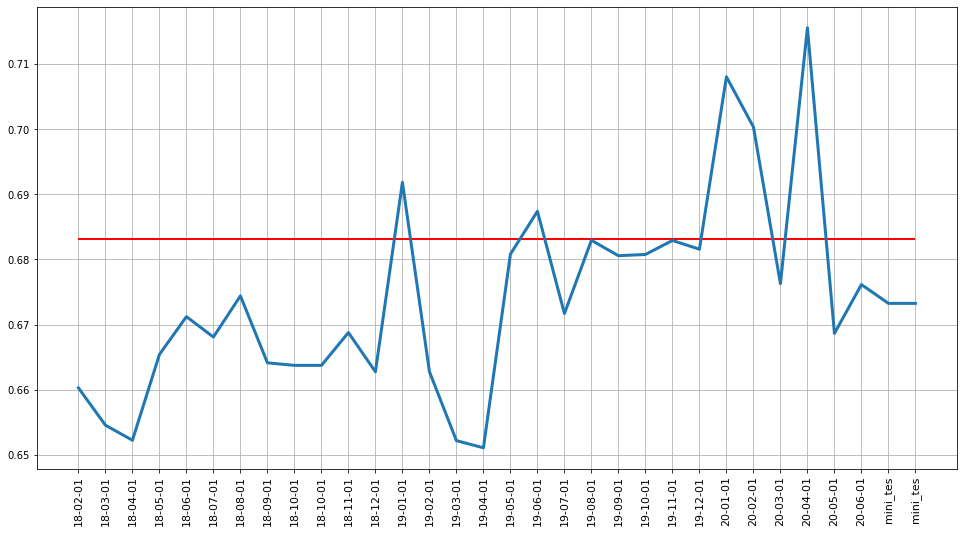

In [3]:
import matplotlib.pyplot as plt
import numpy as np

baseline = frame['Ref Acc'].values[0]
frame = frame.sort_values('Eval', axis=0)
fig = plt.figure()
fig.set_size_inches(16.5, 8.5)
ax = plt.axes()
x = list(range(frame.shape[0]))
labels = frame['Eval'].apply(lambda x: x[:8])

y = frame['Eval Acc'].values
plt.plot(x, y, '-', linewidth=3)
ax.hlines(y=baseline, xmin = 0, xmax = max(x), linewidth=2, color='r')

ax.set_xticks(x)
# Set ticks labels for x-axis
ax.set_xticklabels(labels.values, rotation='vertical', fontsize=11)

plt.grid()
plt.show()